<a href="https://colab.research.google.com/github/adenurchalisa/DeepLearning_finalproject/blob/main/FinalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q ultralytics
!pip install -q optuna
!pip install -q tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from PIL import Image
import cv2
from tqdm.auto import tqdm
import random
from ultralytics import YOLO
import shutil
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import drive

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Cek GPU tersedia atau tidak
print("Checking GPU availability...")
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    DEVICE = 0  # Menggunakan GPU pertama
else:
    print("GPU not available, falling back to CPU")
    DEVICE = 'cpu'

Checking GPU availability...
GPU available: Tesla T4


In [5]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
# Path ke dataset dan folder penyimpanan dengan nama yang berbeda untuk menghindari konflik
dataset_dir = "/content/drive/MyDrive/deep learning/dataset_augmented-20250624T035320Z-1-001/dataset_augmented"
model_dir = "/content/drive/MyDrive/deep learning/models"
yolo_dataset_dir = "/content/custom_yolo_dataset_processed"  # Nama folder yang berbeda

# Pastikan direktori model ada
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [15]:
# Kategori dan parameter global
CATEGORIES = ["sangat_kotor", "sedang", "sangat_bersih"]
IMG_SIZE = 640  # Ukuran optimal untuk GPU
BATCH_SIZE = 16
EPOCHS = 30
SEED = 42

# Set random seed untuk reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [16]:
# Persiapan dataset untuk YOLO - VERSI TERBARU dengan path absolut
def prepare_yolo_dataset(dataset_dir, output_dir):
    """
    Menyiapkan dataset dalam format yang cocok untuk YOLOv5
    """
    # Hapus output_dir jika sudah ada untuk memastikan mulai bersih
    if os.path.exists(output_dir):
        print(f"Removing existing {output_dir}")
        shutil.rmtree(output_dir)

    # Buat struktur folder
    os.makedirs(f"{output_dir}/images/train", exist_ok=True)
    os.makedirs(f"{output_dir}/images/val", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/train", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/val", exist_ok=True)

    # Dataset split info
    train_data = []
    val_data = []

    # Class mapping
    class_to_idx = {cat: i for i, cat in enumerate(CATEGORIES)}

    # Get full absolute paths
    abs_output_dir = os.path.abspath(output_dir)
    abs_train_dir = os.path.join(abs_output_dir, "images", "train")
    abs_val_dir = os.path.join(abs_output_dir, "images", "val")

    # Create dataset.yaml dengan jalur absolut
    with open(f"{output_dir}/custom_dataset.yaml", "w") as f:
        f.write(f"path: {abs_output_dir}\n")
        f.write(f"train: {abs_train_dir}\n")  # Jalur absolut ke folder train
        f.write(f"val: {abs_val_dir}\n")  # Jalur absolut ke folder val
        f.write(f"nc: {len(CATEGORIES)}\n")
        f.write(f"names: {CATEGORIES}\n")

    for category in CATEGORIES:
        category_dir = os.path.join(dataset_dir, category)
        if not os.path.exists(category_dir):
            print(f"Warning: Category directory {category_dir} does not exist")
            continue

        images = [f for f in os.listdir(category_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Shuffle images
        random.shuffle(images)

        # Split into train/val (80/20)
        split_idx = int(len(images) * 0.8)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        print(f"Category {category}: {len(train_images)} training, {len(val_images)} validation")

        # Process training images
        for img_name in train_images:
            src_path = os.path.join(category_dir, img_name)
            dst_path = os.path.join(output_dir, "images", "train", img_name)
            shutil.copy(src_path, dst_path)

            # Create label file (for classification with YOLO)
            label_path = os.path.join(output_dir, "labels", "train", f"{os.path.splitext(img_name)[0]}.txt")
            with open(label_path, "w") as f:
                f.write(f"{class_to_idx[category]}")

            train_data.append((dst_path, class_to_idx[category]))

        # Process validation images
        for img_name in val_images:
            src_path = os.path.join(category_dir, img_name)
            dst_path = os.path.join(output_dir, "images", "val", img_name)
            shutil.copy(src_path, dst_path)

            # Create label file
            label_path = os.path.join(output_dir, "labels", "val", f"{os.path.splitext(img_name)[0]}.txt")
            with open(label_path, "w") as f:
                f.write(f"{class_to_idx[category]}")

            val_data.append((dst_path, class_to_idx[category]))

    print(f"Prepared {len(train_data)} training and {len(val_data)} validation images")

    # Verifikasi dataset
    print("\nVerifikasi YOLO dataset:")
    print(f"Dataset YAML exists: {os.path.exists(os.path.join(output_dir, 'custom_dataset.yaml'))}")
    print(f"Train images directory exists: {os.path.exists(os.path.join(output_dir, 'images', 'train'))}")
    print(f"Number of training images: {len(os.listdir(os.path.join(output_dir, 'images', 'train')))}")
    print(f"Number of validation images: {len(os.listdir(os.path.join(output_dir, 'images', 'val')))}")

    # Print isi file dataset.yaml
    print("\nIsi file custom_dataset.yaml:")
    with open(os.path.join(output_dir, "custom_dataset.yaml"), "r") as f:
        print(f.read())

    return train_data, val_data, os.path.join(output_dir, "custom_dataset.yaml")


In [17]:
# Proses dataset ke format YOLO
print("Processing dataset to YOLO format...")
train_data, val_data, dataset_yaml_path = prepare_yolo_dataset(dataset_dir, yolo_dataset_dir)

Processing dataset to YOLO format...
Category sangat_kotor: 252 training, 63 validation
Category sedang: 256 training, 65 validation
Category sangat_bersih: 248 training, 62 validation
Prepared 756 training and 190 validation images

Verifikasi YOLO dataset:
Dataset YAML exists: True
Train images directory exists: True
Number of training images: 756
Number of validation images: 190

Isi file custom_dataset.yaml:
path: /content/custom_yolo_dataset_processed
train: /content/custom_yolo_dataset_processed/images/train
val: /content/custom_yolo_dataset_processed/images/val
nc: 3
names: ['sangat_kotor', 'sedang', 'sangat_bersih']



In [18]:
# Hyperparameter tuning untuk model klasifikasi dengan dataset yang sudah dikonfigurasi
def optimize_classification_model(n_trials=10, dataset_yaml=None):
    print("\nMemulai hyperparameter tuning untuk model klasifikasi...")

    if dataset_yaml is None:
        print("ERROR: Dataset YAML path is not provided.")
        return {}

    # Definisikan fungsi objective untuk Optuna
    def objective(trial):
        # Parameter yang akan dioptimalkan
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
        img_size = trial.suggest_categorical("img_size", [384, 512, 640])
        dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
        weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

        # Load pre-trained YOLO model
        model = YOLO('yolov5s.pt')

        # Configure model for classification
        model_config = {
            'task': 'classify',
            'data': dataset_yaml,  # Gunakan path yang diberikan
            'epochs': 5,  # Fewer epochs for tuning
            'batch': batch_size,
            'imgsz': img_size,
            'patience': 3,
            'lr0': learning_rate,
            'optimizer': 'Adam',
            'weight_decay': weight_decay,
            'dropout': dropout_rate,
            'device': DEVICE,  # Menggunakan GPU jika tersedia
            'project': model_dir,
            'name': f'tune_trial_{trial.number}',
            'exist_ok': True
        }

        # Train model
        try:
            results = model.train(**model_config)

            # Get validation accuracy
            val_accuracy = results.results_dict.get('metrics/accuracy_top1', 0)
            return val_accuracy
        except Exception as e:
            print(f"Error during trial {trial.number}: {e}")
            return 0  # Return 0 if training fails

    # Create Optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    # Get best parameters
    best_params = study.best_params
    best_accuracy = study.best_value

    print(f"\nBest hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    print(f"Best validation accuracy: {best_accuracy:.4f}")

    # Visualize optimization history
    try:
        plt.figure(figsize=(10, 6))
        plot_optimization_history(study)
        plt.title("Optimization History")
        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, 'optimization_history.png'))
        plt.show()

        plt.figure(figsize=(10, 6))
        plot_param_importances(study)
        plt.title("Hyperparameter Importance")
        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, 'param_importances.png'))
        plt.show()
    except Exception as e:
        print(f"Could not visualize optimization results: {e}")

    return best_params


In [19]:
# Training model klasifikasi berbasis YOLO dengan parameter terbaik
def train_classification_model(best_params=None, dataset_yaml=None):
    if dataset_yaml is None:
        print("ERROR: Dataset YAML path is not provided.")
        return None, None

    # Load a pre-trained YOLO model
    model = YOLO('yolov5s.pt')

    # Default parameters
    if best_params is None or len(best_params) == 0:
        best_params = {
            'learning_rate': 0.001,
            'batch_size': 16,
            'img_size': 640,
            'dropout_rate': 0.3,
            'weight_decay': 5e-4
        }
        print("\nMenggunakan parameter default:")
    else:
        print("\nMenggunakan parameter hasil tuning:")

    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Configure model for classification
    model_config = {
        'task': 'classify',
        'data': dataset_yaml,  # Gunakan path yang diberikan
        'epochs': EPOCHS,
        'batch': best_params.get('batch_size', 16),
        'imgsz': best_params.get('img_size', 640),
        'patience': 10,
        'lr0': best_params.get('learning_rate', 0.001),
        'weight_decay': best_params.get('weight_decay', 5e-4),
        'dropout': best_params.get('dropout_rate', 0.3),
        'optimizer': 'Adam',
        'device': DEVICE,  # Menggunakan GPU jika tersedia
        'project': model_dir,
        'name': 'classification_model',
        'exist_ok': True
    }

    # Start training
    print("\nTraining classification model dengan parameter optimal...")
    results = model.train(**model_config)

    # Print final metrics
    metrics = results.results_dict
    print("\nClassification Model Metrics:")
    for k, v in metrics.items():
        if k.startswith('metrics/'):
            print(f"  {k}: {v}")

    # Save the model
    try:
        model.export(format='onnx')
    except Exception as e:
        print(f"Error exporting model: {e}")

    classification_model_path = os.path.join(model_dir, 'classification_model', 'weights', 'best.pt')
    print(f"\nClassification model saved to: {classification_model_path}")

    return model, classification_model_path


In [20]:
# Get pre-trained model for detection
def get_detection_model():
    print("\nUsing pre-trained YOLOv5 model for object detection...")
    model = YOLO('yolov5s.pt')
    return model, 'yolov5s.pt'

In [21]:
# Fungsi untuk evaluasi model klasifikasi
def evaluate_classification_model(model, data_dir):
    print("\nEvaluating classification model...")
    # Create confusion matrix
    val_dir = os.path.join(data_dir, "images/val")
    val_images = [os.path.join(val_dir, f) for f in os.listdir(val_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Get true labels
    true_labels = []
    for img_path in val_images:
        img_name = os.path.basename(img_path)
        label_path = os.path.join(data_dir, "labels/val", f"{os.path.splitext(img_name)[0]}.txt")
        with open(label_path, "r") as f:
            true_labels.append(int(f.read().strip()))

    # Get predictions - GPU dapat memproses lebih banyak gambar
    predictions = []
    confidences = []

    for img_path in tqdm(val_images, desc="Predicting"):
        results = model.predict(img_path, verbose=False)[0]
        pred_class = results.probs.top1
        pred_conf = results.probs.top1conf.item()

        predictions.append(pred_class)
        confidences.append(pred_conf)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'confusion_matrix.png'))
    plt.show()

    # Classification report
    report = classification_report(true_labels, predictions, target_names=CATEGORIES)
    print("\nClassification Report:")
    print(report)

    return true_labels, predictions, confidences


In [22]:
# Fungsi hybrid untuk prediksi gambar - menggabungkan klasifikasi dan deteksi
def hybrid_predict(classification_model, detection_model, image_path):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 1. Prediksi klasifikasi kebersihan (untuk prediksi bisa gunakan CPU untuk konsistensi)
    classification_results = classification_model.predict(image_path, verbose=False)[0]
    cleanliness_class = CATEGORIES[classification_results.probs.top1]
    cleanliness_conf = classification_results.probs.top1conf.item() * 100

    # 2. Deteksi objek
    detection_results = detection_model.predict(image_path, verbose=False)[0]

    # Get detected objects
    detected_objects = []
    for box in detection_results.boxes:
        cls = int(box.cls.item())
        conf = box.conf.item() * 100
        label = detection_model.names[cls]

        # Only include relevant objects with good confidence
        if conf > 45 and label in ['bottle', 'cup', 'trash', 'garbage', 'bag', 'backpack', 'handbag', 'cell phone', 'laptop']:
            detected_objects.append({
                'label': label,
                'confidence': conf,
                'box': box.xyxy[0].tolist()  # Convert tensor to list
            })

    # Count trash-related objects
    trash_count = len(detected_objects)

    # Visualize results
    plt.figure(figsize=(12, 8))

    # Show image with detection boxes
    plt.imshow(img_rgb)

    # Draw bounding boxes
    for obj in detected_objects:
        box = obj['box']
        label = obj['label']
        conf = obj['confidence']

        # Draw rectangle
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                          fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Add label
        plt.text(box[0], box[1]-10, f"{label} {conf:.1f}%",
                 color='white', fontsize=10, backgroundcolor='red')

    # Add classification result
    title_color = 'red' if cleanliness_class == 'sangat_kotor' else 'orange' if cleanliness_class == 'sedang' else 'green'
    plt.title(f"Tingkat Kebersihan: {cleanliness_class} ({cleanliness_conf:.1f}%)\nObjek Terdeteksi: {trash_count}",
              color=title_color, fontsize=16)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"\nHasil Klasifikasi Kebersihan:")
    for i, prob in enumerate(classification_results.probs.data):
        print(f"  {CATEGORIES[i]}: {prob*100:.2f}%")

    print(f"\nObjek Terdeteksi ({trash_count} total):")
    for i, obj in enumerate(detected_objects):
        print(f"  {i+1}. {obj['label']}: {obj['confidence']:.2f}%")

    # Overall analysis
    analysis = ""
    if cleanliness_class == 'sangat_kotor' and trash_count > 3:
        analysis = "Area ini sangat kotor dengan banyak sampah terdeteksi. Perlu pembersihan segera."
    elif cleanliness_class == 'sangat_kotor' and trash_count <= 3:
        analysis = "Area terlihat sangat kotor, namun sedikit objek sampah terdeteksi. Mungkin ada masalah lain seperti tanah/air yang tercemar."
    elif cleanliness_class == 'sedang' and trash_count > 3:
        analysis = "Area ini cukup bersih, namun masih banyak objek sampah terdeteksi. Perlu dibersihkan lebih lanjut."
    elif cleanliness_class == 'sedang' and trash_count <= 3:
        analysis = "Area ini cukup bersih dengan beberapa objek sampah. Kondisi cukup baik namun masih bisa ditingkatkan."
    elif cleanliness_class == 'sangat_bersih' and trash_count > 2:
        analysis = "Area ini terlihat bersih, namun ada beberapa objek terdeteksi. Pastikan objek tersebut bukan sampah."
    else:  # sangat_bersih dan sedikit/tidak ada sampah
        analysis = "Area ini sangat bersih dengan sedikit/tidak ada sampah. Kondisi sangat baik."

    print(f"\nAnalisis: {analysis}")

    return {
        'cleanliness': {
            'class': cleanliness_class,
            'confidence': cleanliness_conf,
            'probabilities': {CATEGORIES[i]: float(prob)*100 for i, prob in enumerate(classification_results.probs.data)}
        },
        'objects': detected_objects,
        'analysis': analysis
    }


In [23]:
# Fungsi demo untuk memprediksi gambar yang diupload user
def predict_uploaded_image(classification_model, detection_model):
    from google.colab import files

    print("Silahkan upload gambar lingkungan untuk diklasifikasi dan deteksi objek:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nMemprediksi gambar: {filename}")
        hybrid_predict(classification_model, detection_model, filename)

In [24]:
# Main process
print("Model Hybrid: Klasifikasi Kebersihan + Object Detection (Versi GPU)")

Model Hybrid: Klasifikasi Kebersihan + Object Detection (Versi GPU)


[I 2025-06-25 17:38:39,888] A new study created in memory with name: no-name-638ac3a8-6b72-4e88-8736-45fc2fec51ac



YOLO dataset successfully created at: /content/custom_yolo_dataset_processed
Using dataset config: /content/custom_yolo_dataset_processed/custom_dataset.yaml

Memulai hyperparameter tuning untuk model klasifikasi...
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.3128979014048213, dynamic=False, embed=None, epochs=5

[I 2025-06-25 17:38:41,143] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.0007885692017729967, 'batch_size': 8, 'img_size': 640, 'dropout_rate': 0.3128979014048213, 'weight_decay': 0.00031780141969659344}. Best is trial 0 with value: 0.0.


Error during trial 0: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.241131371165058, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=

[I 2025-06-25 17:38:41,285] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.0015020742535745448, 'batch_size': 8, 'img_size': 384, 'dropout_rate': 0.241131371165058, 'weight_decay': 0.00012779730886703538}. Best is trial 0 with value: 0.0.


Error during trial 1: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.4138863186711029, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok

[I 2025-06-25 17:38:41,447] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.0017802363925316029, 'batch_size': 8, 'img_size': 640, 'dropout_rate': 0.4138863186711029, 'weight_decay': 1.0548561519919627e-05}. Best is trial 0 with value: 0.0.


Error during trial 2: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.4273391740954861, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_o

[I 2025-06-25 17:38:41,598] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.0002749018551965559, 'batch_size': 32, 'img_size': 640, 'dropout_rate': 0.4273391740954861, 'weight_decay': 0.0003983756153662587}. Best is trial 0 with value: 0.0.


Error during trial 3: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.39279500553057345, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_

[I 2025-06-25 17:38:41,732] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 0.0010102738780130057, 'batch_size': 16, 'img_size': 384, 'dropout_rate': 0.39279500553057345, 'weight_decay': 3.6049600107658804e-05}. Best is trial 0 with value: 0.0.


Error during trial 4: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.4722405517778699, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_o

[I 2025-06-25 17:38:41,870] Trial 5 finished with value: 0.0 and parameters: {'learning_rate': 0.0004247892353006925, 'batch_size': 16, 'img_size': 640, 'dropout_rate': 0.4722405517778699, 'weight_decay': 0.00024552660385835604}. Best is trial 0 with value: 0.0.


Error during trial 5: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.4328961695330472, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok

[I 2025-06-25 17:38:42,022] Trial 6 finished with value: 0.0 and parameters: {'learning_rate': 0.005053678460455955, 'batch_size': 8, 'img_size': 512, 'dropout_rate': 0.4328961695330472, 'weight_decay': 1.455239861887078e-05}. Best is trial 0 with value: 0.0.


Error during trial 6: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.3643394878119001, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_o

[I 2025-06-25 17:38:42,160] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.00011612233691883185, 'batch_size': 32, 'img_size': 512, 'dropout_rate': 0.3643394878119001, 'weight_decay': 1.913872612381293e-05}. Best is trial 0 with value: 0.0.


Error during trial 7: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.40457655791408165, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_

[I 2025-06-25 17:38:42,302] Trial 8 finished with value: 0.0 and parameters: {'learning_rate': 0.0035218796772213405, 'batch_size': 16, 'img_size': 512, 'dropout_rate': 0.40457655791408165, 'weight_decay': 8.707492450638785e-05}. Best is trial 0 with value: 0.0.


Error during trial 8: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.23348849203168534, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_o

[I 2025-06-25 17:38:42,459] Trial 9 finished with value: 0.0 and parameters: {'learning_rate': 0.0009018497509662883, 'batch_size': 8, 'img_size': 512, 'dropout_rate': 0.23348849203168534, 'weight_decay': 3.6990216750907726e-05}. Best is trial 0 with value: 0.0.


Error during trial 9: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'

Best hyperparameters:
  learning_rate: 0.0007885692017729967
  batch_size: 8
  img_size: 640
  dropout_rate: 0.3128979014048213
  weight_decay: 0.00031780141969659344
Best validation accuracy: 0.0000


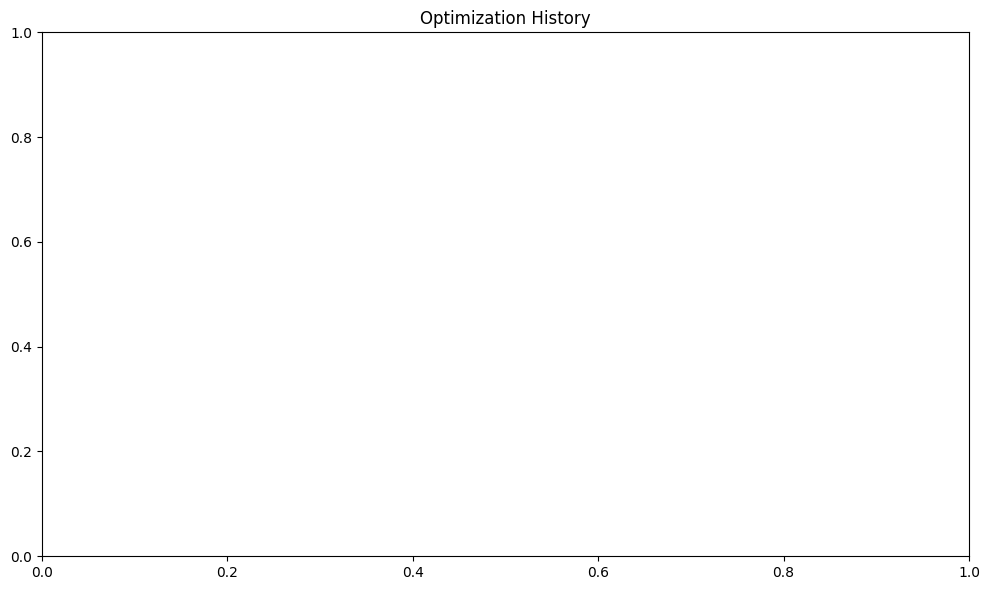

Could not visualize optimization results: Encountered zero total variance in all trees.
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


Menggunakan parameter hasil tuning:
  learning_rate: 0.0007885692017729967
  batch_size: 8
  img_size: 640
  dropout_rate: 0.3128979014048213
  weight_decay: 0.00031780141969659344

Training classification model dengan parameter optimal...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_yolo_dataset_processed/custom_dataset.yaml, degrees=0.0, d

RuntimeError: Dataset '/content/custom_yolo_dataset_processed/custom_dataset.yaml' error ❌ [Errno 20] Not a directory: '/content/custom_yolo_dataset_processed/custom_dataset.yaml/train'

<Figure size 1000x600 with 0 Axes>

In [25]:
# Periksa apakah dataset YOLO telah dibuat dengan benar
if train_data and val_data and os.path.exists(dataset_yaml_path):
    print(f"\nYOLO dataset successfully created at: {yolo_dataset_dir}")
    print(f"Using dataset config: {dataset_yaml_path}")

    # Step 1: Hyperparameter Tuning untuk Model Klasifikasi
    best_params = optimize_classification_model(n_trials=10, dataset_yaml=dataset_yaml_path)

    # Step 2: Train Classification Model dengan parameter optimal
    classification_model, classification_model_path = train_classification_model(best_params, dataset_yaml=dataset_yaml_path)

    # Step 3: Get pre-trained Detection Model
    detection_model, detection_model_path = get_detection_model()

    # Step 4: Evaluate Classification Model
    true_labels, predictions, confidences = evaluate_classification_model(classification_model, yolo_dataset_dir)

    # Step 5: Demo Prediction
    print("\nModel sudah siap untuk memprediksi gambar baru!")
    predict_uploaded_image(classification_model, detection_model)

    print("\nProses selesai! Model hybrid telah berhasil dilatih dan dievaluasi dengan GPU.")
else:
    print("\nERROR: Dataset YOLO tidak dibuat dengan benar. Periksa log untuk detail lebih lanjut.")